In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

# Historical ECMWF Review in Ethiopia

In [185]:
import xarray as xr
import pandas as pd
import tqdm
import os
from dotenv import load_dotenv
from azure.storage.blob import ContainerClient
import rioxarray as rxr
import geopandas as gpd
import zipfile
import matplotlib.pyplot as plt
import re
import plotly.express as px
from dateutil.relativedelta import relativedelta

load_dotenv()

PROD_BLOB_SAS = os.getenv("DSCI_AZ_SAS_PROD")
PROD_BLOB_NAME = "imb0chd0prod"
PROD_BLOB_URL = f"https://{PROD_BLOB_NAME}.blob.core.windows.net/"
PROD_BLOB_GLB_URL = PROD_BLOB_URL + "raster" + "?" + PROD_BLOB_SAS
prod_rst_container_client = ContainerClient.from_container_url(PROD_BLOB_GLB_URL)

DEV_BLOB_SAS = os.getenv("DSCI_AZ_SAS_DEV")
DEV_BLOB_NAME = "imb0chd0dev"
DEV_BLOB_URL = f"https://{DEV_BLOB_NAME}.blob.core.windows.net/"
DEV_BLOB_PRJ_URL = DEV_BLOB_URL + "projects" + "?" + DEV_BLOB_SAS
dev_prj_container_client = ContainerClient.from_container_url(DEV_BLOB_PRJ_URL)

Load in ETH CODS

In [16]:
fname = "Admin_2024.gdb.zip"
blob_name = f"ds-aa-eth-drought/raw/cod_ab/{fname}"
adm_level = 2

blob_client = dev_prj_container_client.get_blob_client(blob_name)
download_file_path = os.path.join(os.getcwd(), "data", fname)
with open(download_file_path, "wb") as download_file:
    download_file.write(blob_client.download_blob().readall())

extracted_dir = os.path.join(os.getcwd(), "data")
with zipfile.ZipFile(download_file_path, "r") as zip_ref:
    zip_ref.extractall(extracted_dir)

In [17]:
gdf3 = gpd.read_file(
    "data/Admin_2024.gdb", layer=f"eth_admbnda_adm{adm_level}_csa_bofedb_2024"
)
gdf0 = gpd.read_file("data/Admin_2024.gdb", layer=f"eth_admbnda_adm0_csa_bofedb_2024")

Filtering for geographic coverage focused on areas with September start of OND season (see [this slide](https://docs.google.com/presentation/d/1vZayUcBbA2NJfJWsO4vxskxP-xnPsRoJG10YNzwkClM/edit#slide=id.g2e7474f9ddb_0_1)). The selected Zones are hard-coded based on [this previous analysis](https://github.com/OCHA-DAP/ds-aa-eth-drought/blob/5d7a19d36f1dfb2bbd6312ddb9f8622396a63fae/analysis/01_1_reviewing_july_forecast_for_ond.R#L36-L41).

In [18]:
ond_zones = [
    "ET0508",
    "ET0806",
    "ET0808",
    "ET0411",
    "ET0412",
    "ET0810",
    "ET0511",
    "ET0807",
    "ET0507",
    "ET0421",
    "ET0410",
    "ET0504",
    "ET0502",
    "ET0802",
    "ET0414",
    "ET0503",
    "ET0809",
    "ET0505",
    "ET0509",
    "ET0510",
    "ET0506",
    "ET0812",
    "ET0415",
    "ET0422",
]

gdf3_sel = gdf3[gdf3.admin2Pcode.isin(ond_zones)]

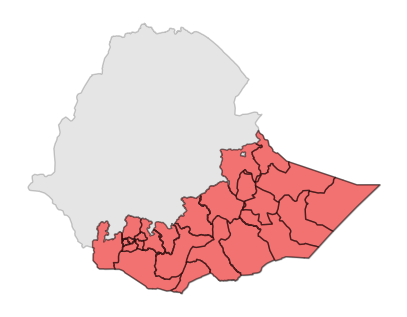

In [19]:
ax = gdf0.plot(color="gray", edgecolor="black", alpha=0.2, figsize=(5, 5))
gdf3_sel.plot(ax=ax, color="red", edgecolor="black", alpha=0.5)

ax.axis("off")
plt.show()

# Also create a single dissolved gdf of the area of interest
gdf_sel = gdf3_sel.dissolve()

## Process and clip the COGs

Now load in and process the historical precipitation data. Let's start by taking in the SEAS5 seasonal forecasts. Also get the updated 2024 data from Azure

In [190]:
def process_cogs(cogs_list, gdf_clip):

    minx, miny, maxx, maxy = gdf_clip.total_bounds
    das_tprate = []
    das_tp = []

    # Total days in the month, given leadtime month
    days_in_month = {2: 31, 3: 30, 4: 31}

    for blob_name in tqdm.tqdm(cogs_list):

        cog_url = (
            f"https://{PROD_BLOB_NAME}.blob.core.windows.net/raster/"
            f"{blob_name}?{PROD_BLOB_SAS}"
        )

        date_in = pd.to_datetime(blob_name.split(".")[0][-14:-4])
        lt = int(blob_name.split("-")[2][-5:-4])
        year = int(blob_name.split("-")[0][-4:])
        days = days_in_month[lt]

        da_in = rxr.open_rasterio(cog_url, masked=True, chunks={"x": 225, "y": 900})
        da_in = da_in.sel(x=slice(minx, maxx), y=slice(maxy, miny))

        da_in = da_in.squeeze(drop=True)
        da_in["year"] = year
        da_in["forecast_date"] = date_in + relativedelta(months=lt)
        da_in = da_in.persist()

        # Get total precipitation
        da_tp = da_in * 3600 * 24 * days * 1000
        da_tp = da_tp.assign_attrs(
            units="mm", long_name="Total accumulated precipitation"
        )

        das_tp.append(da_tp)
        das_tprate.append(da_in)

    # ds_tprate = xr.concat(das_tprate, dim="pub_date")
    ds_tp = xr.concat(das_tp, dim="forecast_date").rio.set_spatial_dims(
        x_dim="x", y_dim="y"
    )
    ds_tp_clip = ds_tp.rio.clip(gdf_clip.geometry)

    return ds_tp_clip

There seems to be grid misalignment issues between the AWS and MARS data, so we're aggregating these separately. This is something to look into more closely in other work.

In [ ]:
# OND dates - for forecasts published in Aug
# File names have the publish date
dates = [f"08-01_lt2", f"08-01_lt3", f"08-01_lt4"]
dates = "|".join(dates)

blob_names_mars = [
    x.name
    for x in prod_rst_container_client.list_blobs(
        name_starts_with="seas5/mars/processed"
    )
    if re.search(dates, x.name)
]

blob_names_aws = [
    x.name
    for x in prod_rst_container_client.list_blobs(
        name_starts_with="seas5/aws/processed"
    )
    if re.search(dates, x.name)
]

In [201]:
ds_aws = process_cogs(blob_names_aws, gdf_sel)
ds_mars = process_cogs(blob_names_mars, gdf_sel)

100%|██████████| 129/129 [01:16<00:00,  1.68it/s]


Let's plot both to sanity check

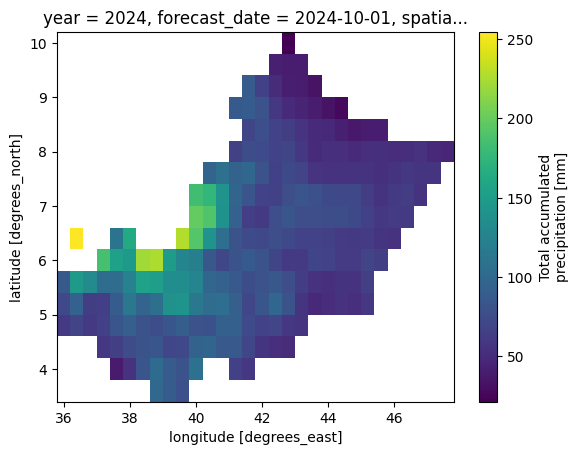

In [203]:
ds_aws.sel({"forecast_date": "2024-10-01"}).plot()

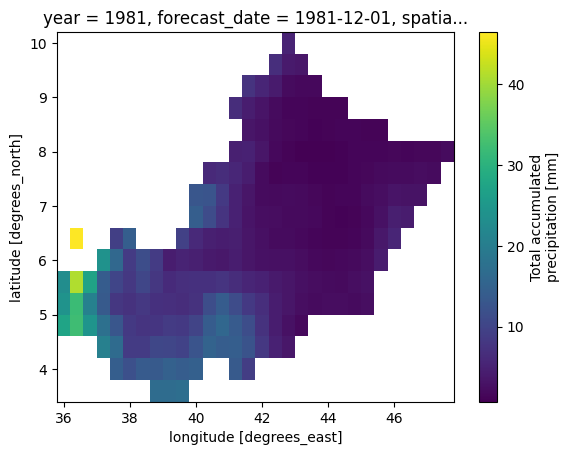

In [208]:
ds_mars.sel({"forecast_date": "1981-12-01"}).plot()

## Take the sum by year

In [218]:
# For 2024 data from AWS -- just a single value for OND
ds_2024 = ds_aws.sum(dim=["x", "y", "forecast_date"])
precip_2024 = int(ds_2024.values)

In [220]:
ds_sum = ds_mars.groupby("year").sum()
ds_total_sum = ds_sum.sum(dim=["x", "y"])
df = (
    ds_total_sum.to_dataframe(name="total_ond_precip")
    .reset_index()
    .drop(columns="spatial_ref")
)

Add the 2024 observation to the overall dataframe

In [236]:
df = pd.concat(
    [df, pd.DataFrame([{"year": 2024, "total_ond_precip": precip_2024}])],
    ignore_index=True,
)

In [243]:
mean = df.total_ond_precip.mean()

## Make a plot of the overall distribution

In [228]:
def plot_distribution(df, drought_years=[2010, 2020, 2022]):

    fig = px.histogram(df, x="total_ond_precip", nbins=20, template="simple_white")
    fig.update_layout(
        yaxis=dict(title="Count of Years"),
        xaxis=dict(title="Total OND Precipitation (mm)"),
        title=dict(
            text="Distribution of Forecasted Total OND Precipitation in Southern Ethiopia from 1981 to 2023 Based on ECMWF August Publication",
        ),
        font=dict(family="Arial"),
    )

    fig.update_traces(marker_color="#35B678")

    for year in drought_years:
        precip = df.loc[df["year"] == year, "total_ond_precip"].values[0]
        # TODO: For some reason vline isn't working, so slightly hacking with vrect
        fig.add_vrect(x0=(precip - 25), x1=(precip + 25), opacity=1, fillcolor="red")
        fig.add_annotation(
            text=f"<b>{year}</b>",
            x=(precip + 300),
            y=10,
            showarrow=False,
            textangle=90,
            font=dict(color="red"),
        )

    return fig

In [247]:
fig = plot_distribution(df)

In [248]:
fig.add_vrect(
    x0=(precip_2024 - 25), x1=(precip_2024 + 25), opacity=1, fillcolor="black"
)
fig.add_annotation(
    text=f"<b>2024</b>",
    x=(precip_2024 - 300),
    y=10,
    showarrow=False,
    textangle=90,
    font=dict(color="black"),
)

In [249]:
fig.show()

Let's get the mean/median of the precipitation values as well... The total accumulated precipitation for OND 2024 is slightly below both the mean and median historical precipitation for OND. 

In [241]:
df.total_ond_precip.mean()

30156.187855113636

In [242]:
df.total_ond_precip.median()

28367.376953125